In [4]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
np.warnings.filterwarnings('ignore')
np.random.seed(1001)

import os
import sys
import shutil
from pathlib import Path

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

matplotlib.style.use('ggplot')
%matplotlib inline

#DATAROOT = 'SmallBookImagesDataset'
DATAROOT = '/mnt/dataset/SmallBookImagesDataset'

datapath = Path(DATAROOT)

from keras.applications.vgg16 import VGG16

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras import backend as K
import keras

from skimage.io import imread
from scipy.misc import imresize
from keras.preprocessing.image import ImageDataGenerator
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

### Model
def model_imagenet_x(input_shape, num_classes, weights='imagenet', show_layers=False):
    # create the base pre-trained model
    #base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model = VGG16(weights=weights, include_top=False, input_shape=input_shape)

    # add a global spatial average pooling layer & FC
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)

    if show_layers:
        for i, layer in enumerate(base_model.layers):
            print(i, layer.name)

    predictions = Dense(num_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

### Configuration management class
class Config:
    def __init__(self,
                 learning_rate=0.0001,
                 batch_size=16,
                 shape=[224, 224, 3],
                 use_mixup=True,
                 use_augmentations=True,
                verbose=1):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.shape = shape
        self.verbose = verbose
        self.use_mixup = use_mixup
        self.use_augmentations = use_augmentations

### Dataset distribution utility
def get_class_distribution(y):
    # y_cls can be one of [OH label, index of class, class label name]
    # convert OH to index of class
    y_cls = [np.argmax(one) for one in y] if len(np.array(y).shape) == 2 else y
    # y_cls can be one of [index of class, class label name]
    classset = sorted(list(set(y_cls)))
    sample_distribution = {cur_cls:len([one for one in y_cls if one == cur_cls]) for cur_cls in classset}
    return sample_distribution

def get_class_distribution_list(y, num_classes):
    dist = get_class_distribution(y)
    assert(y[0].__class__ != str) # class index or class OH label only
    list_dist = np.zeros((num_classes))
    for i in range(num_classes):
        if i in dist:
            list_dist[i] = dist[i]
    return list_dist

from imblearn.over_sampling import RandomOverSampler
def balance_class_by_over_sampling(X, y): # Naive: all sample has equal weights
    Xidx = [[xidx] for xidx in range(len(X))]
    y_cls = [np.argmax(one) for one in y]
    classset = sorted(list(set(y_cls)))
    sample_distribution = [len([one for one in y_cls if one == cur_cls]) for cur_cls in classset]
    nsamples = np.max(sample_distribution)
    flat_ratio = {cls:nsamples for cls in classset}
    Xidx_resampled, y_cls_resampled = RandomOverSampler(ratio=flat_ratio, random_state=42).fit_sample(Xidx, y_cls)
    sampled_index = [idx[0] for idx in Xidx_resampled]
    return np.array([X[idx] for idx in sampled_index]), np.array([y[idx] for idx in sampled_index])

### Dataset management class
class LabeledDataset:
    image_suffix = ['.jpg', '.JPG']
    def __init__(self, datapath, shape, batch_size):
        self.datapath = Path(datapath)
        self.shape = shape
        self.batch_size = batch_size
    def load_image(filename, shape, rescale_factor):
        img = imread(filename)
        return imresize(img, shape[:2]) * rescale_factor
    def load_as_image(self):
        # datapath shall contain label/file labeled data files
        train_files = sorted([x for x in self.datapath.glob('*/*') if x.suffix in LabeledDataset.image_suffix])
        self.X_train = np.array([LabeledDataset.load_image(filename, self.shape, rescale_factor=1/255.)
                                    for filename in train_files])
        y_train_label = [filename.parent.name for filename in train_files]
        self.labels = sorted(list(set(y_train_label)))
        self.label2int = {label:i for i, label in enumerate(self.labels)}
        self.y_train = to_categorical([self.label2int[label] for label in y_train_label])
    def split_train_valid(self, test_size=0.2, random_state=42):
        self.cur_X_train, self.cur_X_valid, self.cur_y_train, self.cur_y_valid = train_test_split(
            self.X_train, 
            self.y_train, 
            test_size=test_size,
            random_state=random_state)
        self.cur_X_train, self.cur_y_train = \
            balance_class_by_over_sampling(self.cur_X_train, self.cur_y_train)
    def load_test_as_image(self, test_datapath):
        test_datapath = Path(test_datapath)
        test_files = sorted([x for x in test_datapath.glob('*') if x.suffix in LabeledDataset.image_suffix])
        self.X_test = np.array([LabeledDataset.load_image(filename, self.shape, rescale_factor=1/255.)
                                for filename in test_files])
    def create_test_generator(self, IDG_options={}):
        test_datagen = ImageDataGenerator(**IDG_options)
        y_test_dummy = to_categorical([0 for _ in range(len(self.X_test))])
        self.test_gen = test_datagen.flow(self.X_test, y_test_dummy,
                                          batch_size=len(self.X_test), shuffle=False) ########## self.batch_size
    def create_generator(self, conf, IDG_options={}):
        aug_datagen = ImageDataGenerator(**IDG_options)
        if conf.use_mixup:
            self.train_gen = MixupGenerator(self.cur_X_train, self.cur_y_train, 
                                            alpha=1.0, batch_size=self.batch_size,
                                            datagen=aug_datagen)()
        else:
            self.train_gen = aug_datagen.flow(self.cur_X_train, self.cur_y_train, 
                                              batch_size=self.batch_size)
        plain_datagen = ImageDataGenerator()
        self.valid_gen = plain_datagen.flow(self.cur_X_valid, self.cur_y_valid,
                                                              batch_size=self.batch_size, shuffle=False)
    def train_steps_per_epoch(self):
        return len(self.cur_X_train) // self.batch_size
    def valid_steps_per_epoch(self):
        return len(self.cur_X_valid) // self.batch_size

def reset_generator():
    if conf.use_augmentations:
        IDG_options={'horizontal_flip': True, 'vertical_flip': True,
                     'rotation_range': 40, 'zoom_range': 0.3,
                      'preprocessing_function': get_random_eraser(v_l=np.min(d.X_train),                                                           
                                                    v_h=np.max(d.X_train))}
    else:
        IDG_options={}
    d.create_generator(conf, IDG_options)

In [5]:
conf = Config(batch_size=8, shape=[224, 224, 3], 
              use_mixup=False, use_augmentations=False)

d = LabeledDataset(datapath / 'train', conf.shape, conf.batch_size)
d.load_as_image()
d.split_train_valid()

## Model performance per trained layers

In [ ]:
model, base_model = model_imagenet_x(input_shape=conf.shape, num_classes=len(d.labels), weights='imagenet')
evaluate_test(model, 'model_weights_block4_conv1_imagenet_full_aug.h5',
              datapath / 'test', test_expected_preds, {}, show_detail=False)

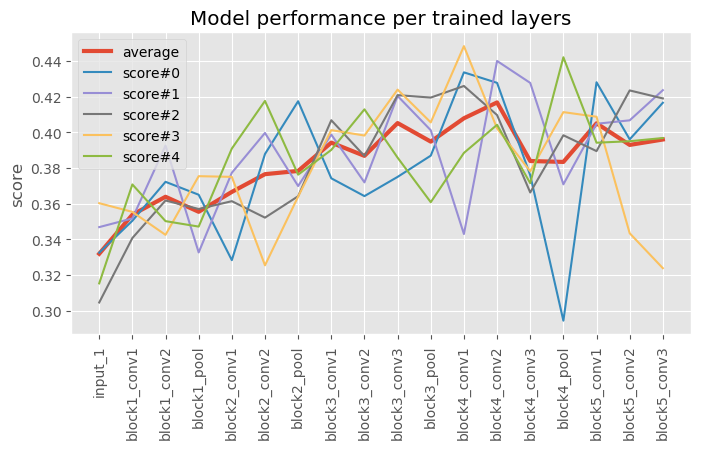

In [37]:
pred_scores = np.load('imagenet_score_by_freeze_layer.npy')
configurable_layer_names = [layer.name for layer in model.layers[:18]] # 18 is the last conv layer of VGG19

plt.figure(figsize=(8, 4), dpi=100)
plt.plot(configurable_layer_names, np.mean(pred_scores, axis=0), linewidth=3, label='average')
for i, s in enumerate(pred_scores):
    plt.plot(configurable_layer_names, s, label='score#%d' % i)
plt.xticks(rotation=90)
plt.ylabel('score')
plt.title('Model performance per trained layers')
plt.legend()
plt.show()

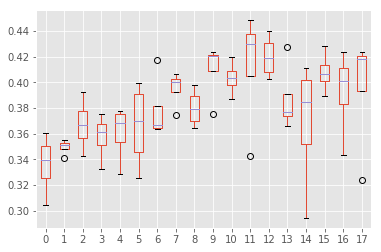

In [35]:
import pandas as pd
df = pd.DataFrame(sall)
plt.figure(figsize=(8, 4))
df.plot.box()

### How this data was calculated

Followings were done separatedly, due to computational cost.

In [1]:
#for _ in range(5):
#    hists, score_bgs, score_alls = attempt_w_fixed_layers(train_points=reversed(configurable_layer_names), epochs=100)